In [25]:
import os, json, random, math, time
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
print("TensorFlow:", tf.__version__)

from sklearn.preprocessing import label_binarize

TensorFlow: 2.16.1


In [2]:
# ========= USER CONFIG =========
ROOT_DIR = "../dataset_4_100img"   # <-- change to your dataset root
OUTPUT_DIR = "tfrecord_pipeline"    # where TFRecords, labels.json, model will be saved
IMG_SIZE = (224, 224)                 # target size (H, W)
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42
SHUFFLE_BUFFER = 2048
AUTOTUNE = tf.data.AUTOTUNE
USE_MIXED_PRECISION = False           # set True if you have a GPU supporting it
USE_GZIP_TFRECORDS = True             # TFRecord compression


In [3]:
# Create output dirs
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
TFRECORD_DIR = str(Path(OUTPUT_DIR) / "tfrecords")
Path(TFRECORD_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision enabled.")

In [5]:
# Make results reproducible (as much as possible)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# Small helper
def list_classes(root_dir: str) -> List[str]:
    classes = [p.name for p in sorted(Path(root_dir).glob("*")) if p.is_dir()]
    if not classes:
        raise ValueError(f"No class subdirectories found in {root_dir}")
    return classes

CLASSES = list_classes(ROOT_DIR)
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES)

Classes: ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu']


In [7]:
# Cell 2: Scan & Split
def list_images_with_labels(root_dir: str, classes: List[str]) -> List[Tuple[str, int]]:
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}
    paths = []
    for idx, cname in enumerate(classes):
        for p in Path(root_dir, cname).rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                paths.append((str(p), idx))
    return paths

all_items = list_images_with_labels(ROOT_DIR, CLASSES)
random.shuffle(all_items)
print(f"Total images found: {len(all_items)}")

# split indices
n_total = len(all_items)
n_test = int(round(TEST_SPLIT * n_total))
n_val  = int(round(VAL_SPLIT  * n_total))
n_train = n_total - n_val - n_test

train_items = all_items[:n_train]
val_items   = all_items[n_train:n_train+n_val]
test_items  = all_items[n_train+n_val:]

print(f"Train: {len(train_items)} | Val: {len(val_items)} | Test: {len(test_items)}")

# Save label map for later inference
with open(Path(OUTPUT_DIR, "labels.json"), "w") as f:
    json.dump({"classes": CLASSES}, f, indent=2)
print("Saved label map to labels.json")

Total images found: 467
Train: 327 | Val: 70 | Test: 70
Saved label map to labels.json


### 3) TFRecord Writing Utilities

In [8]:
# Cell 3: TFRecord writers

def _bytes_feature(value: bytes) -> tf.train.Feature:
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value: int) -> tf.train.Feature:
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image_bytes: bytes, label: int, height: int, width: int, channels: int) -> bytes:
    feature = {
        "image": _bytes_feature(image_bytes),
        "label": _int64_feature(label),
        "height": _int64_feature(height),
        "width": _int64_feature(width),
        "channels": _int64_feature(channels),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

def load_and_encode_image(path: str, target_size: Tuple[int, int], channels: int) -> Tuple[bytes, int, int, int]:
    """
    Loads an image via TF, decodes any format, resizes, and re-encodes to JPEG bytes for consistent storage.
    """
    img_raw = tf.io.read_file(path)
    img = tf.io.decode_image(img_raw, channels=channels, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, target_size, method="bilinear", antialias=True)
    img = tf.clip_by_value(img, 0.0, 1.0)
    img_uint8 = tf.image.convert_image_dtype(img, tf.uint8)  # back to 0..255
    img_jpeg = tf.io.encode_jpeg(img_uint8, quality=95)      # encode to JPEG bytes
    return img_jpeg.numpy(), target_size[0], target_size[1], channels

def write_tfrecord(split_name: str, items: List[Tuple[str, int]], records_per_shard: int = 2000):
    """
    Writes sharded TFRecords with (image, label, shape) for a given split.
    """
    if not items:
        print(f"No items for split {split_name}, skipping.")
        return

    compression = "GZIP" if USE_GZIP_TFRECORDS else None
    options = tf.io.TFRecordOptions(compression_type=compression) if compression else None

    num_shards = max(1, math.ceil(len(items) / records_per_shard))
    shard_sizes = [len(items) // num_shards] * num_shards
    for i in range(len(items) % num_shards):
        shard_sizes[i] += 1

    start = 0
    for shard_id, shard_size in enumerate(shard_sizes):
        end = start + shard_size
        shard_items = items[start:end]
        start = end

        shard_path = Path(TFRECORD_DIR, f"{split_name}-{shard_id:03d}.tfrecord")
        with tf.io.TFRecordWriter(str(shard_path), options=options) as w:
            for path, label in shard_items:
                try:
                    img_bytes, h, w_, c = load_and_encode_image(path, IMG_SIZE, CHANNELS)
                    example = serialize_example(img_bytes, label, h, w_, c)
                    w.write(example)
                except Exception as e:
                    print(f"[WARN] Failed {path}: {e}")
        print(f"Wrote {split_name} shard {shard_id+1}/{num_shards}: {shard_path}")

#### 4) Write Train/Val/Test TFRecords

In [9]:
# Cell 4: Execute writing
write_tfrecord("train", train_items, records_per_shard=2000)
write_tfrecord("val",   val_items,   records_per_shard=2000)
write_tfrecord("test",  test_items,  records_per_shard=2000)

print("TFRecord writing completed.")


2025-11-01 20:02:10.153111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-01 20:02:10.186749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Wrote train shard 1/1: tfrecord_pipeline/tfrecords/train-000.tfrecord
Wrote val shard 1/1: tfrecord_pipeline/tfrecords/val-000.tfrecord
Wrote test shard 1/1: tfrecord_pipeline/tfrecords/test-000.tfrecord
TFRecord writing completed.


#### 5) TFRecord Reading & tf.data Pipeline

In [10]:
# Cell 5: Dataset readers

compression_type = "GZIP" if USE_GZIP_TFRECORDS else None

feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64),
    "height": tf.io.FixedLenFeature([], tf.int64),
    "width": tf.io.FixedLenFeature([], tf.int64),
    "channels": tf.io.FixedLenFeature([], tf.int64),
}

def parse_example(record):
    ex = tf.io.parse_single_example(record, feature_desc)
    img = tf.io.decode_jpeg(ex["image"], channels=CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    label = tf.cast(ex["label"], tf.int32)
    return img, label

def augment(img, label):
    # Minimal, safe augmentations
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img, label

def make_dataset(split: str, training: bool) -> tf.data.Dataset:
    files = tf.io.gfile.glob(str(Path(TFRECORD_DIR, f"{split}-*.tfrecord")))
    if not files:
        raise FileNotFoundError(f"No TFRecord files found for split '{split}'")
    ds = tf.data.TFRecordDataset(files, compression_type=compression_type, num_parallel_reads=AUTOTUNE)
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset("train", training=True)
val_ds   = make_dataset("val",   training=False)
test_ds  = make_dataset("test",  training=False)

for sample_imgs, sample_labels in train_ds.take(1):
    print("Sample batch:", sample_imgs.shape, sample_labels.shape)


Sample batch: (32, 224, 224, 3) (32,)


2025-11-01 20:02:13.247938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


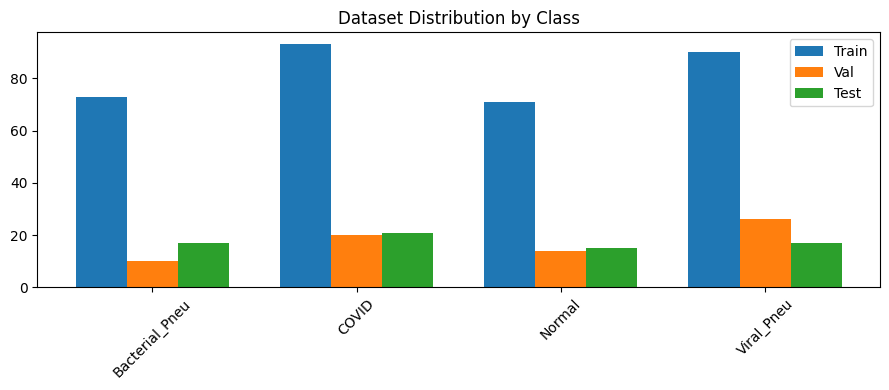

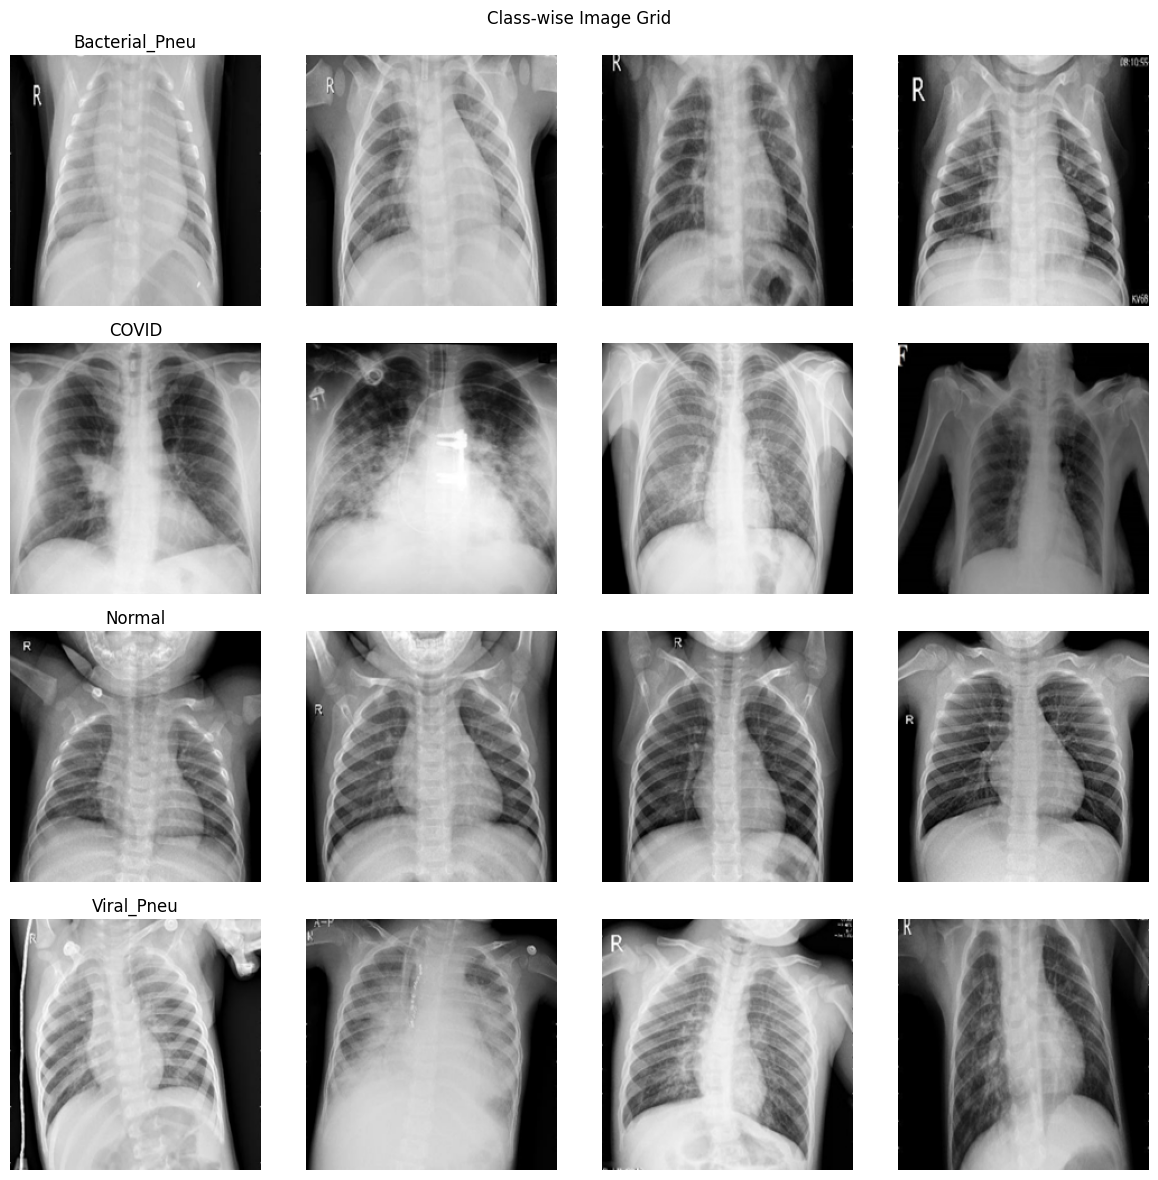

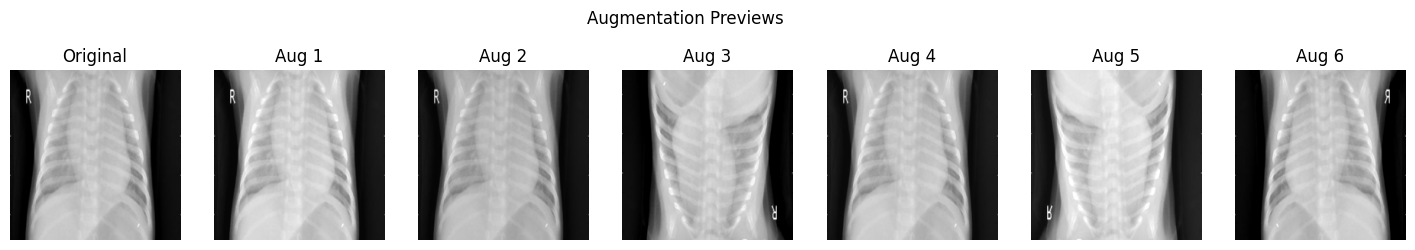

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# --- Distribution Bar & Pie ---
def count_per_class(items):
    counts = np.zeros(len(CLASSES), int)
    for _, c in items: counts[c]+=1
    return counts

train_c, val_c, test_c = map(count_per_class, [train_items, val_items, test_items])
x = np.arange(len(CLASSES)); w=0.25
plt.figure(figsize=(9,4))
plt.bar(x-w, train_c, width=w, label="Train")
plt.bar(x, val_c, width=w, label="Val")
plt.bar(x+w, test_c, width=w, label="Test")
plt.xticks(x, CLASSES, rotation=45)
plt.title("Dataset Distribution by Class"); plt.legend(); plt.tight_layout(); plt.show()

# --- Image Grid per Class ---
def show_class_grid(items, k=4):
    per_class = defaultdict(list)
    for p, c in items:
        if len(per_class[c])<k: per_class[c].append(p)
    rows=len(CLASSES); cols=k
    fig, axs = plt.subplots(rows, cols, figsize=(3*cols,3*rows))
    for r, cname in enumerate(CLASSES):
        for c in range(cols):
            ax = axs[r,c]; ax.axis("off")
            try:
                img = Image.open(per_class[r][c]).resize(IMG_SIZE[::-1])
                ax.imshow(img)
                if c==0: ax.set_title(cname)
            except: pass
    plt.suptitle("Class-wise Image Grid"); plt.tight_layout(); plt.show()
show_class_grid(train_items)

# --- Augmentation Preview ---
def augment(img,label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img,0.1)
    img = tf.image.random_contrast(img,0.9,1.1)
    return img,label

def load_img_tensor(path):
    img=tf.io.decode_image(tf.io.read_file(path),channels=CHANNELS)
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=tf.image.resize(img,IMG_SIZE)
    return img

img_path=train_items[0][0]
base=load_img_tensor(img_path)
fig,axs=plt.subplots(1,7,figsize=(18,3))
axs[0].imshow(base); axs[0].set_title("Original")
for i in range(6):
    a,_=augment(base,0)
    axs[i+1].imshow(tf.clip_by_value(a,0,1)); axs[i+1].set_title(f"Aug {i+1}")
for ax in axs: ax.axis("off")
plt.suptitle("Augmentation Previews"); plt.show()


#### 6) Build the Model (Transfer Learning or Small CNN)

In [12]:
# Cell 6: Model definition (MobileNetV2 backbone)

from tensorflow import keras
from tensorflow.keras import layers
def build_model():
    base=keras.applications.MobileNetV2(input_shape=(*IMG_SIZE,CHANNELS),include_top=False,weights="imagenet")
    base.trainable=False
    inp=keras.Input(shape=(*IMG_SIZE,CHANNELS))
    x=keras.applications.mobilenet_v2.preprocess_input(inp*255.0)
    x=base(x,training=False)
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dropout(0.2)(x)
    out=layers.Dense(NUM_CLASSES,activation="softmax")(x)
    return keras.Model(inp,out)

model=build_model()

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### 7) Train (with EarlyStopping & Checkpointing)

In [13]:
# Cell 7: Training
ckpt_path = str(Path(OUTPUT_DIR, "model_best.keras"))

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
     11/Unknown 8s 360ms/step - accuracy: 0.2932 - loss: 1.6507

2025-11-01 20:02:23.021944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/updaterpc/miniconda3/envs/drAsif/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from None to 0.54286, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:02:24.948108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 602ms/step - accuracy: 0.3639 - loss: 1.5249 - val_accuracy: 0.5429 - val_loss: 1.0700
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5151 - loss: 1.0687

2025-11-01 20:02:32.698351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy improved from 0.54286 to 0.65714, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:02:33.439110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.5566 - loss: 1.0241 - val_accuracy: 0.6571 - val_loss: 0.8388
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6541 - loss: 0.8264

2025-11-01 20:02:37.763853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 3: val_accuracy improved from 0.65714 to 0.80000, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:02:38.560123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.6575 - loss: 0.8291 - val_accuracy: 0.8000 - val_loss: 0.6685
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6851 - loss: 0.7256

2025-11-01 20:02:42.583034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy improved from 0.80000 to 0.82857, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:02:43.351180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.6972 - loss: 0.7100 - val_accuracy: 0.8286 - val_loss: 0.5844
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7792 - loss: 0.6070

2025-11-01 20:02:47.360257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 5: val_accuracy did not improve from 0.82857
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step - accuracy: 0.7676 - loss: 0.6082 - val_accuracy: 0.8000 - val_loss: 0.5668
Epoch 6/10


2025-11-01 20:02:48.261901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7299 - loss: 0.6256

2025-11-01 20:02:52.412756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_accuracy improved from 0.82857 to 0.85714, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:02:53.289253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 481ms/step - accuracy: 0.7339 - loss: 0.6044 - val_accuracy: 0.8571 - val_loss: 0.4933
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7914 - loss: 0.5741

2025-11-01 20:02:57.382095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 7: val_accuracy did not improve from 0.85714
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.7890 - loss: 0.5577 - val_accuracy: 0.8143 - val_loss: 0.5345
Epoch 8/10


2025-11-01 20:02:58.280437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8176 - loss: 0.4404

2025-11-01 20:03:02.376279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy improved from 0.85714 to 0.87143, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:03:03.171772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.7951 - loss: 0.5170 - val_accuracy: 0.8714 - val_loss: 0.4230
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7967 - loss: 0.5117

2025-11-01 20:03:07.202178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 9: val_accuracy did not improve from 0.87143
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - accuracy: 0.8073 - loss: 0.4914 - val_accuracy: 0.8429 - val_loss: 0.4954
Epoch 10/10


2025-11-01 20:03:08.059256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8008 - loss: 0.4534

2025-11-01 20:03:11.870335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_accuracy did not improve from 0.87143
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.8073 - loss: 0.4544 - val_accuracy: 0.8429 - val_loss: 0.4002


2025-11-01 20:03:12.658413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### 8) Optional: Fine-tune the Backbone

In [14]:
# Cell 8: Fine-tuning (optional but often improves accuracy)
model.get_layer(index=1).trainable = True  # unfreeze base
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(3, EPOCHS // 2),
    callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
    ]
)


Epoch 1/5
     11/Unknown 37s 2s/step - accuracy: 0.3721 - loss: 1.9693

2025-11-01 20:03:50.253016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_accuracy improved from None to 0.84286, saving model to tfrecord_pipeline/model_best.keras


2025-11-01 20:03:52.139438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4434 - loss: 1.5980 - val_accuracy: 0.8429 - val_loss: 0.4846
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7634 - loss: 0.5683

2025-11-01 20:04:14.209290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy did not improve from 0.84286
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7706 - loss: 0.5397 - val_accuracy: 0.8286 - val_loss: 0.6009
Epoch 3/5


2025-11-01 20:04:14.997571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8213 - loss: 0.4426

2025-11-01 20:04:35.111132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 3: val_accuracy did not improve from 0.84286
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8502 - loss: 0.3801 - val_accuracy: 0.7714 - val_loss: 0.6395
Epoch 4/5


2025-11-01 20:04:35.934859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8845 - loss: 0.3326

2025-11-01 20:04:57.229767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy did not improve from 0.84286
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8746 - loss: 0.3363 - val_accuracy: 0.7000 - val_loss: 0.7420


2025-11-01 20:04:57.988855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [15]:
# Cell 9: Evaluation
test_metrics = model.evaluate(test_ds, return_dict=True)
print("Test metrics:", test_metrics)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.7143 - loss: 0.8482
Test metrics: {'accuracy': 0.7142857313156128, 'loss': 0.8482356667518616}


2025-11-01 20:04:58.865473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


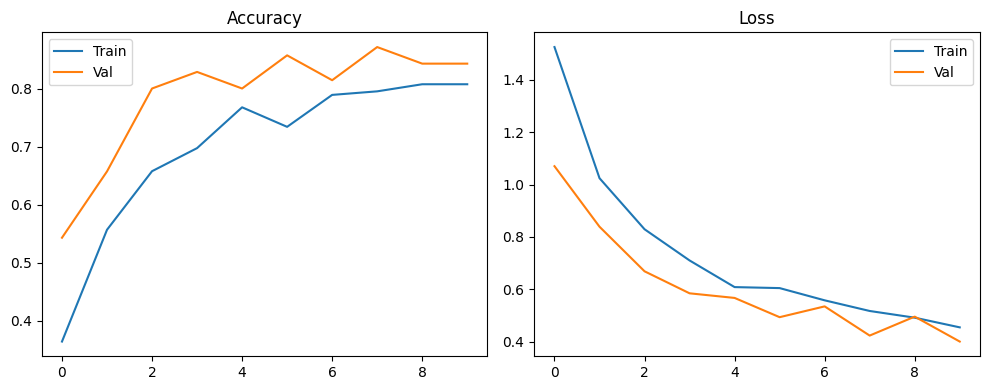

In [16]:
# --- Training & Validation Curves ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["accuracy"]); plt.plot(history.history["val_accuracy"]); 
plt.title("Accuracy"); plt.legend(["Train","Val"])
plt.subplot(1,2,2); plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"]); 
plt.title("Loss"); plt.legend(["Train","Val"])
plt.tight_layout(); plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7143 - loss: 0.8482
Test Accuracy: 0.714


2025-11-01 20:08:44.506028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/updaterpc/miniconda3/envs/drAsif/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-11-01 20:08:45.431989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


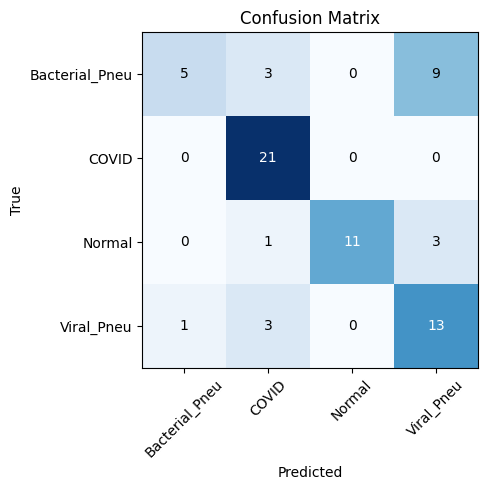

                precision    recall  f1-score   support

Bacterial_Pneu      0.833     0.294     0.435        17
         COVID      0.750     1.000     0.857        21
        Normal      1.000     0.733     0.846        15
    Viral_Pneu      0.520     0.765     0.619        17

      accuracy                          0.714        70
     macro avg      0.776     0.698     0.689        70
  weighted avg      0.768     0.714     0.694        70



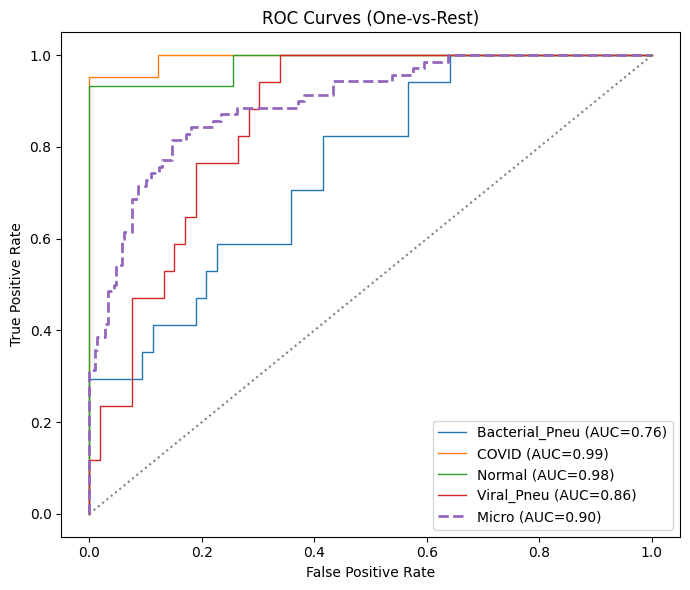

In [26]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.3f}")

# Collect preds
y_true, y_pred, y_prob = [], [], []
for imgs, labels in test_ds:
    p = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(p, axis=1))
    y_prob.extend(p)
y_true = np.array(y_true); y_pred = np.array(y_pred); y_prob = np.array(y_prob)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(range(NUM_CLASSES), CLASSES, rotation=45)
plt.yticks(range(NUM_CLASSES), CLASSES)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i,j], ha="center", va="center",
                 color="white" if cm[i,j]>cm.max()/2 else "black")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=3))

# ROC–AUC
y_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{CLASSES[i]} (AUC={roc_auc[i]:.2f})")
plt.plot(fpr["micro"], tpr["micro"], "--", lw=2, label=f"Micro (AUC={roc_auc['micro']:.2f})")
plt.plot([0,1],[0,1],":",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)"); plt.legend(); plt.tight_layout(); plt.show()


In [27]:
# Cell 10: Save model & class map for inference
final_model_path = str(Path(OUTPUT_DIR, "model_final.keras"))
model.save(final_model_path)
print("Saved final model to:", final_model_path)

# Ensure labels.json already exists with class order used in training (saved earlier).
with open(Path(OUTPUT_DIR, "labels.json")) as f:
    label_info = json.load(f)
class_names = label_info["classes"]
print("Class names:", class_names)


Saved final model to: tfrecord_pipeline/model_final.keras
Class names: ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu']


In [28]:
# Cell 11: Single image prediction
def load_model_and_labels(model_path: str, labels_path: str):
    mdl = tf.keras.models.load_model(model_path)
    with open(labels_path) as f:
        lbls = json.load(f)["classes"]
    return mdl, lbls

infer_model, infer_classes = load_model_and_labels(final_model_path, str(Path(OUTPUT_DIR, "labels.json")))

def prepare_single_image(path: str) -> tf.Tensor:
    img_raw = tf.io.read_file(path)
    img = tf.io.decode_image(img_raw, channels=CHANNELS, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img = tf.expand_dims(img, 0)  # [1,H,W,C]
    # match training preprocessing for MobileNetV2
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img*255.0)  # preprocess_input expects 0..255
    return img

def predict_single(path: str, top_k: int = 3):
    tensor = prepare_single_image(path)
    probs = infer_model.predict(tensor, verbose=0)[0]
    top_idxs = probs.argsort()[-top_k:][::-1]
    results = [(infer_classes[i], float(probs[i])) for i in top_idxs]
    return results

# Example:
results = predict_single("../dataset_4_100img/Viral_Pneu/Pneumonia-Viral (6).png", top_k=3)
print(results)


[('Viral_Pneu', 0.6462674140930176), ('Bacterial_Pneu', 0.21616962552070618), ('Normal', 0.11800897121429443)]


In [31]:
# Cell 12: Batch prediction on a folder of images
def iter_image_paths(folder: str) -> List[str]:
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif", ".tiff"}
    return [str(p) for p in Path(folder).rglob("*") if p.suffix.lower() in exts]

def predict_folder(folder: str, top_k: int = 1) -> List[Dict]:
    paths = iter_image_paths(folder)
    out = []
    for p in paths:
        preds = predict_single(p, top_k=top_k)
        out.append({"path": p, "predictions": preds})
    return out

# Example:
batch_results = predict_folder("../dataset_4_100img/Viral_Pneu/Pneumonia-Viral (6).png", top_k=3)
for r in batch_results[:5]:
     print(r)


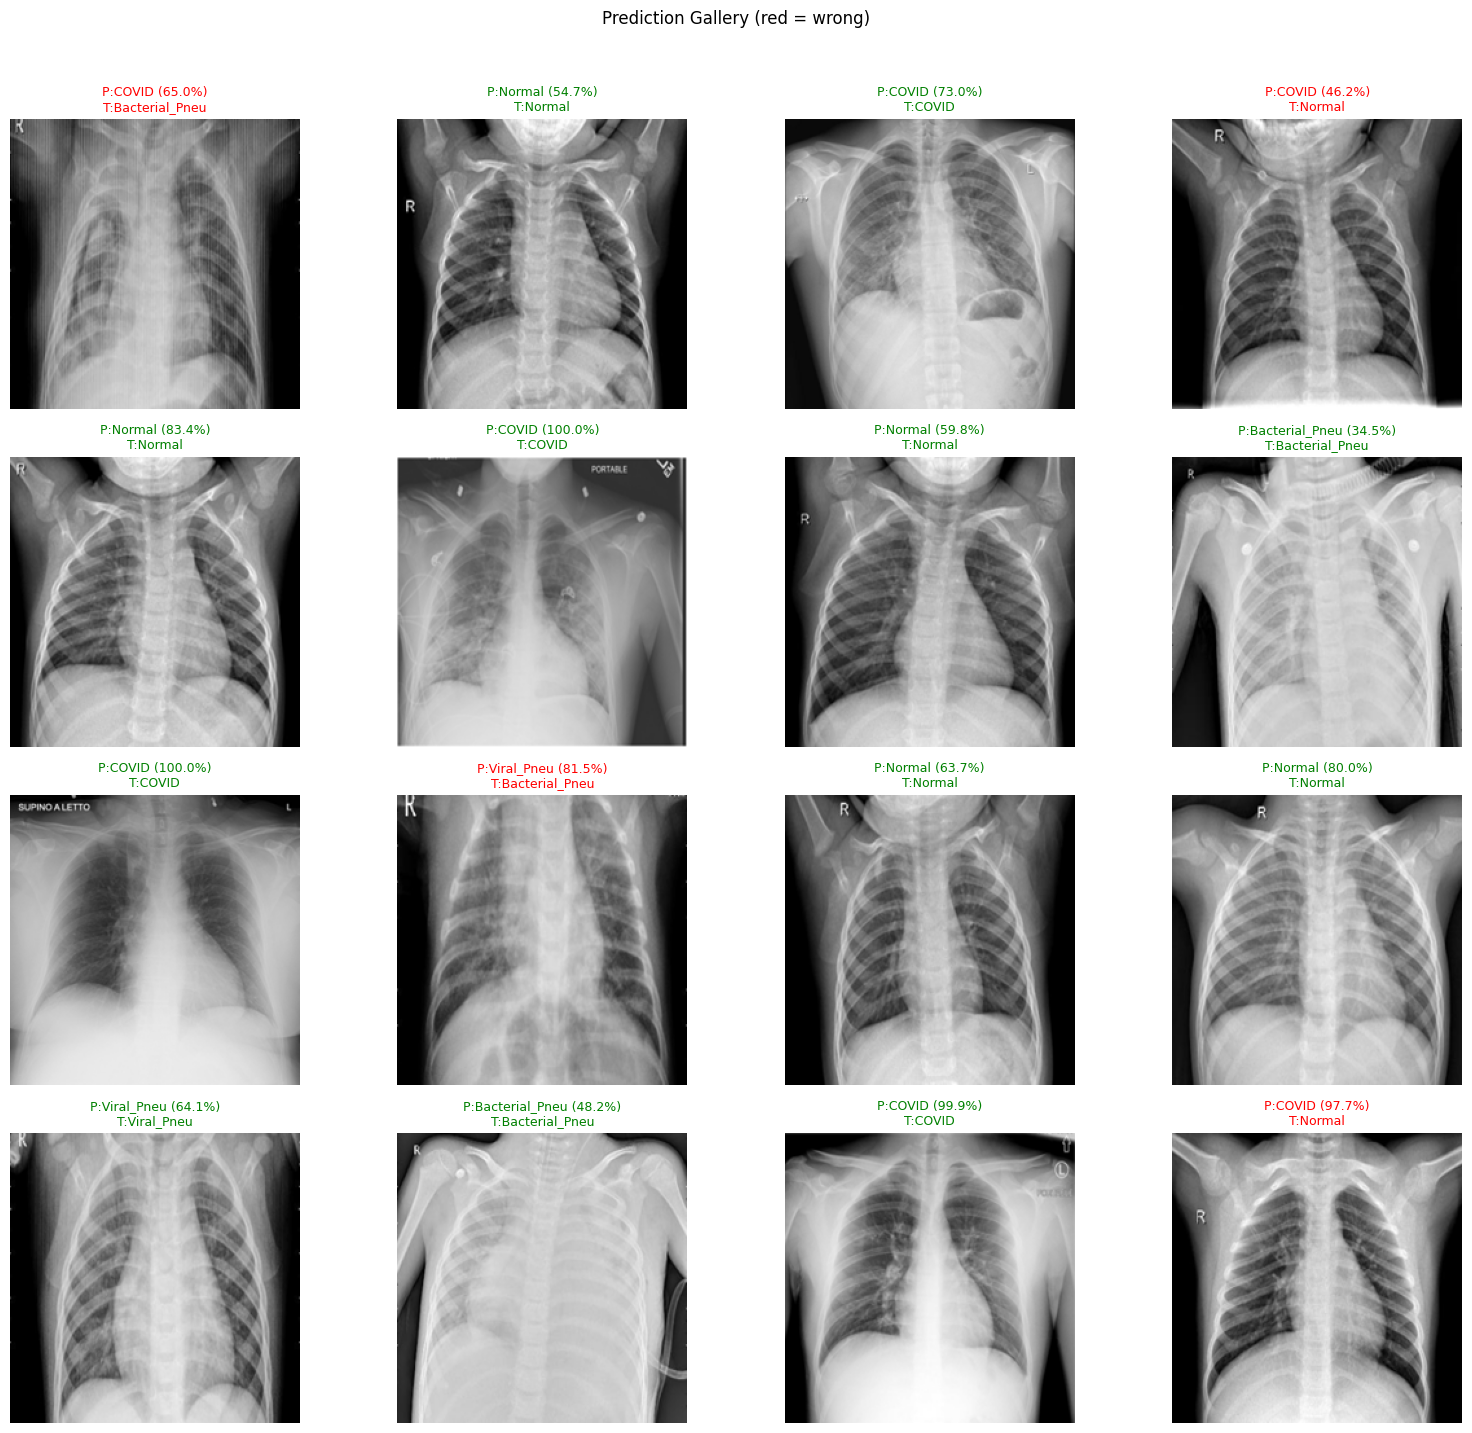

In [34]:
from PIL import Image
import numpy as np

def show_gallery(model, items, n=16):
    subset=items[:n]
    cols=4; rows=int(np.ceil(n/cols))
    fig,axs=plt.subplots(rows,cols,figsize=(4*cols,3.5*rows))
    axs=np.atleast_2d(axs)
    for i,(path,true_lab) in enumerate(subset):
        r,c=divmod(i,cols); ax=axs[r,c]
        ax.axis("off")
        img=Image.open(path).convert("RGB").resize(IMG_SIZE[::-1])
        t=tf.image.convert_image_dtype(np.array(img),tf.float32)[None,...]
        t=tf.keras.applications.mobilenet_v2.preprocess_input(t*255.0)
        probs=model.predict(t,verbose=0)[0]; pred=probs.argmax(); conf=probs[pred]
        color="green" if pred==true_lab else "red"
        ax.imshow(img)
        ax.set_title(f"P:{CLASSES[pred]} ({conf*100:.1f}%)\nT:{CLASSES[true_lab]}",color=color,fontsize=9)
    for j in range(i+1,rows*cols): axs.flat[j].axis("off")
    plt.suptitle("Prediction Gallery (red = wrong)",y=1.02)
    plt.tight_layout(); plt.show()

show_gallery(model, test_items, n=16)
